In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.signal
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from pydub import AudioSegment
import pywt
import optimalK
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_score
from collections import Counter
import itertools
import os
import pickle
import random
from collections import defaultdict

In [2]:
folder_path = '../audios/lab_audios/first_batch/'
with open(f'{folder_path}all_segments.pkl', 'rb') as file:
    all_segments = pickle.load(file)

In [3]:
def band_stop_filter(y, sr, highcut, order=4):
    nyquist = 0.5 * sr
    normal_cutoff = highcut / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = scipy.signal.filtfilt(b, a, y)
    return y_filtered

def process_individual_snippets_with_fft(all_segments, file_names, sr=None):
    processed_segments_fft = []
    
    file_idx = 0
    while file_idx < len(file_names):
        file_name = file_names[file_idx]
        print(f"Loading file: {file_name}")
        
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            file_idx += 1
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]

        for idx, segment in enumerate(file_segments):
            start_time = segment['start_time']
            end_time = segment['end_time']
            
            print(f"Processing snippet {idx + 1}/{len(file_segments)}: {start_time:.2f}s to {end_time:.2f}s")

            start_idx = int(start_time * original_sr)
            end_idx = int(end_time * original_sr)
            
            snippet = y[start_idx:end_idx]
            
            fft_result = np.fft.fft(snippet)
            fft_magnitude = np.abs(fft_result)
            fft_frequencies = np.fft.fftfreq(len(snippet), d=1/original_sr)  # Get frequencies
            
            processed_segments_fft.append({
                'file_name': file_name,
                'start_time': start_time,
                'end_time': end_time,
                'fft_magnitude': fft_magnitude,
                'fft_frequencies': fft_frequencies
            })

        file_idx += 1

    return processed_segments_fft


In [4]:
folder_path = '../audios/lab_audios/first_batch/'
file_names = [f'{folder_path}recording_20240927_204919-{i:02d}.wav' for i in range(1, 17)]
# processed_segments_fft = process_individual_snippets_with_fft(all_segments, file_names)

# # Save the results if needed
# with open(f'{folder_path}processed_segments_fft.pkl', 'wb') as file:
#     pickle.dump(processed_segments_fft, file)

# print("FFT processing complete. Results saved.")


with open(f'{folder_path}processed_segments_fft.pkl', 'rb') as file:
    processed_segments_fft = pickle.load(file)

In [5]:
for segment in processed_segments_fft:
    # Get the fft_frequencies and fft_magnitude fields
    fft_frequencies = segment['fft_frequencies']
    fft_magnitude = segment['fft_magnitude']
    
    # Filter for non-negative frequencies
    non_negative_indices = fft_frequencies >= 0
    segment['fft_frequencies'] = fft_frequencies[non_negative_indices]
    segment['fft_magnitude'] = fft_magnitude[non_negative_indices]

print("Negative frequencies have been removed from all segments.")

Negative frequencies have been removed from all segments.


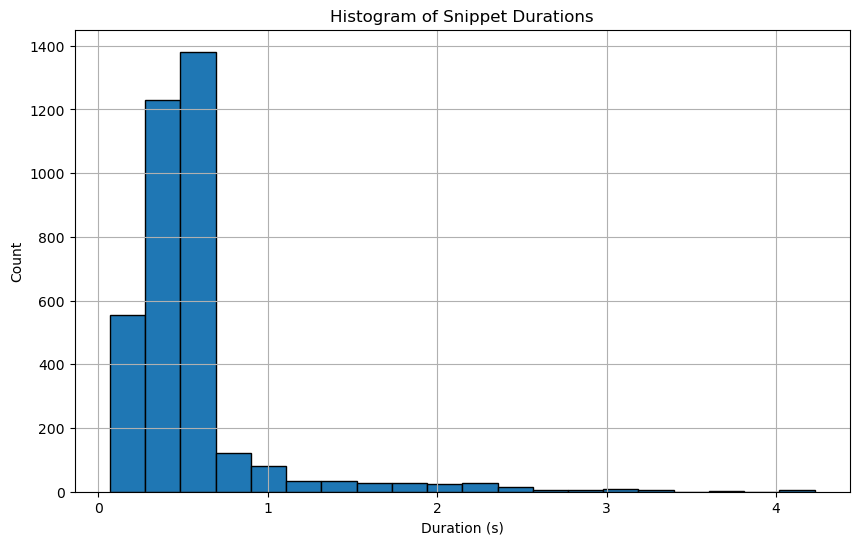

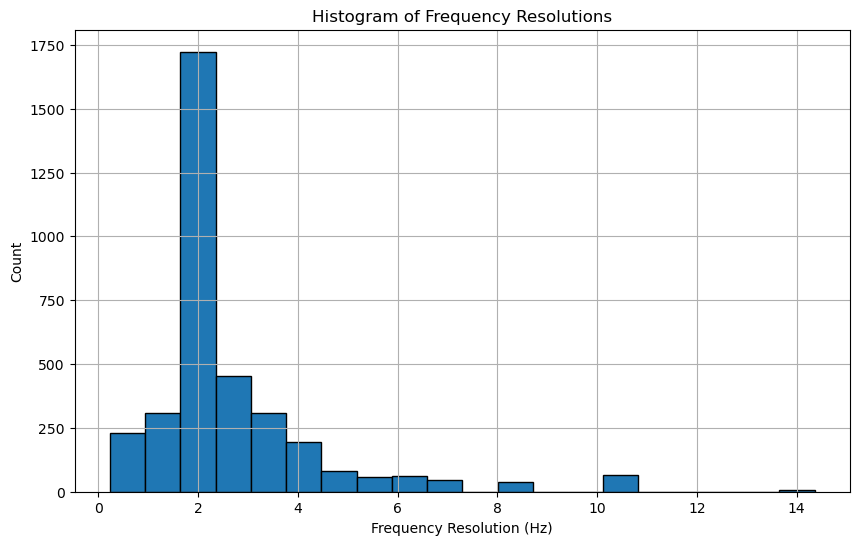

In [6]:
durations = [segment['end_time'] - segment['start_time'] for segment in processed_segments_fft]
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, edgecolor='black')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.title('Histogram of Snippet Durations')
plt.grid(True)
plt.show()

frequency_resolutions = []
for segment in processed_segments_fft:
    fft_frequencies = segment['fft_frequencies']
    positive_frequencies = fft_frequencies[fft_frequencies >= 0]  # Only positive frequencies
    resolution = np.min(np.diff(positive_frequencies))
    frequency_resolutions.append(resolution)

plt.figure(figsize=(10, 6))
plt.hist(frequency_resolutions, bins=20, edgecolor='black')
plt.xlabel('Frequency Resolution (Hz)')
plt.ylabel('Count')
plt.title('Histogram of Frequency Resolutions')
plt.grid(True)
plt.show()

In [7]:
print(processed_segments_fft[0]['fft_magnitude'][0])

0.011074838859822193


In [8]:
def plot_multiple_fft_magnitudes(segments, num_segments_to_plot=10):
    plt.figure(figsize=(15, 10))
    for i, segment in enumerate(segments[:num_segments_to_plot], start=1):
        fft_magnitude = segment['fft_magnitude']
        fft_frequencies = segment['fft_frequencies']
        
        plt.subplot(2, 5, i)
        plt.plot(fft_frequencies, fft_magnitude)
        plt.title(f"Segment {i}")
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid()
    
    plt.tight_layout()
    plt.show()


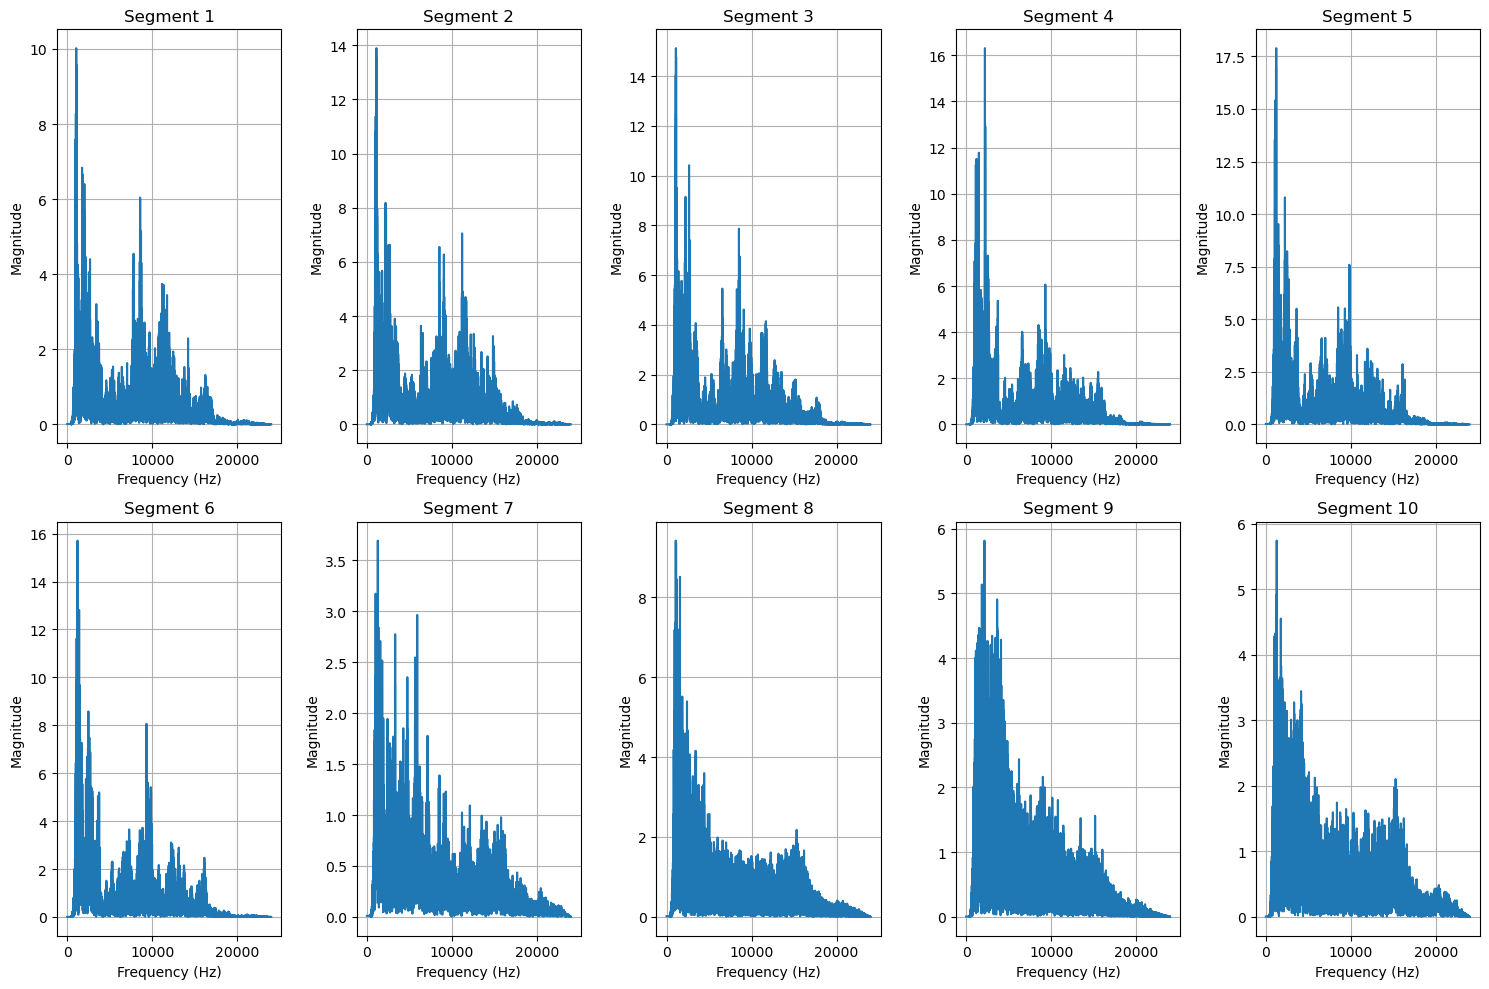

In [9]:
plot_multiple_fft_magnitudes(processed_segments_fft, num_segments_to_plot=10)


In [10]:
def pad_fft_magnitudes(processed_segments_fft):
    # Find the maximum length of fft_magnitude across all segments
    max_length = max(len(segment['fft_magnitude']) for segment in processed_segments_fft)

    # Pad each fft_magnitude array with zeros to match the maximum length
    for segment in processed_segments_fft:
        fft_magnitude = segment['fft_magnitude']
        padded_magnitude = np.pad(fft_magnitude, (0, max_length - len(fft_magnitude)), mode='constant')
        segment['padded_fft_magnitude'] = padded_magnitude

    return processed_segments_fft

In [11]:
processed_segments_fft = pad_fft_magnitudes(processed_segments_fft)

In [14]:
def spectral_clustering_workflow(processed_segments_fft, n_clusters=5):
    print("Extracting and standardizing FFT magnitudes...")
    magnitudes = np.array([segment['padded_fft_magnitude'] for segment in processed_segments_fft])
    scaler = StandardScaler()
    magnitudes_scaled = scaler.fit_transform(magnitudes)

    print(f"Performing spectral clustering with {n_clusters} clusters...")
    spectral_clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='nearest_neighbors',
        random_state=42
    )
    labels = spectral_clustering.fit_predict(magnitudes_scaled)

    for i, segment in enumerate(processed_segments_fft):
        segment['cluster'] = labels[i]

    print("Visualizing cluster sizes...")
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(unique_labels, counts)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Segments')
    plt.title('Cluster Sizes')
    plt.show()

    print("Analyzing and visualizing average magnitudes per cluster...")
    plt.figure(figsize=(10, 6))
    for cluster_id in unique_labels:
        cluster_magnitudes = [segment['padded_fft_magnitude'] for segment in processed_segments_fft if segment['cluster'] == cluster_id]
        avg_magnitude = np.mean(cluster_magnitudes, axis=0)
        plt.plot(avg_magnitude, label=f"Cluster {cluster_id}")

    plt.xlabel('Frequency Bin')
    plt.ylabel('Average Magnitude')
    plt.title('Average FFT Magnitudes for Clusters')
    plt.legend()
    plt.grid()
    plt.show()

    print("Grouping segments by clusters...")
    clusters = defaultdict(list)
    for segment in processed_segments_fft:
        clusters[segment['cluster']].append(segment)

    return clusters

Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Visualizing cluster sizes...


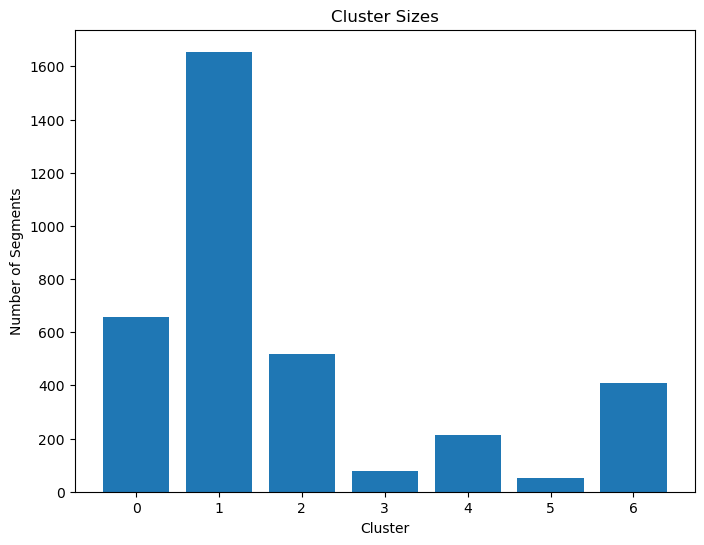

Analyzing and visualizing average magnitudes per cluster...


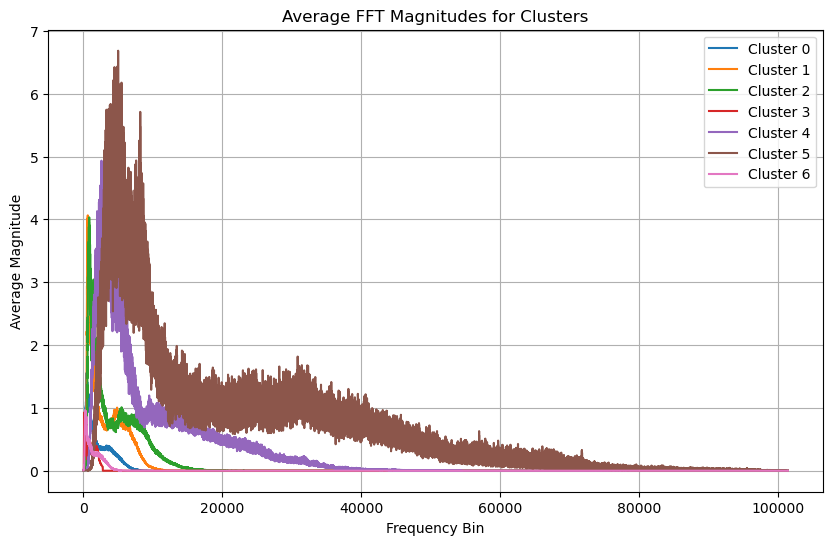

Grouping segments by clusters...
Cluster 1 contains 1655 segments.
Cluster 2 contains 519 segments.
Cluster 0 contains 659 segments.
Cluster 4 contains 214 segments.
Cluster 6 contains 410 segments.
Cluster 5 contains 50 segments.
Cluster 3 contains 77 segments.


In [15]:
# Run the clustering workflow
n_clusters = 7
clusters = spectral_clustering_workflow(processed_segments_fft, n_clusters=n_clusters)

# Access clusters for further analysis
for cluster_id, cluster_segments in clusters.items():
    print(f"Cluster {cluster_id} contains {len(cluster_segments)} segments.")


In [16]:
def plot_cluster_magnitudes(clusters):
    """
    Plot FFT magnitudes for each cluster, including individual magnitudes and average magnitude.

    Args:
        clusters (dict): A dictionary where keys are cluster IDs and values are lists of segments.
    """
    print("Plotting individual magnitudes and average magnitude for each cluster...")
    for cluster_id, cluster_segments in clusters.items():
        plt.figure(figsize=(10, 6))
        for segment in cluster_segments:
            plt.plot(segment['padded_fft_magnitude'], color='gray', alpha=0.3, linewidth=0.5)

        # Calculate and plot the average magnitude
        magnitudes = [segment['padded_fft_magnitude'] for segment in cluster_segments]
        avg_magnitude = np.mean(magnitudes, axis=0)
        plt.plot(avg_magnitude, color='red', linewidth=2, label='Average Magnitude')

        plt.title(f"Cluster {cluster_id}: FFT Magnitudes")
        plt.xlabel('Frequency Bin')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True)
        plt.show()

Plotting individual magnitudes and average magnitude for each cluster...


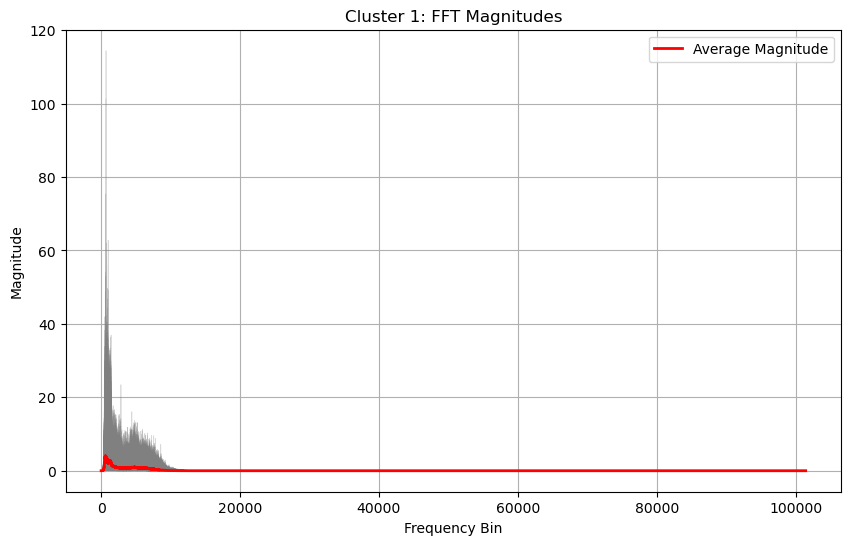

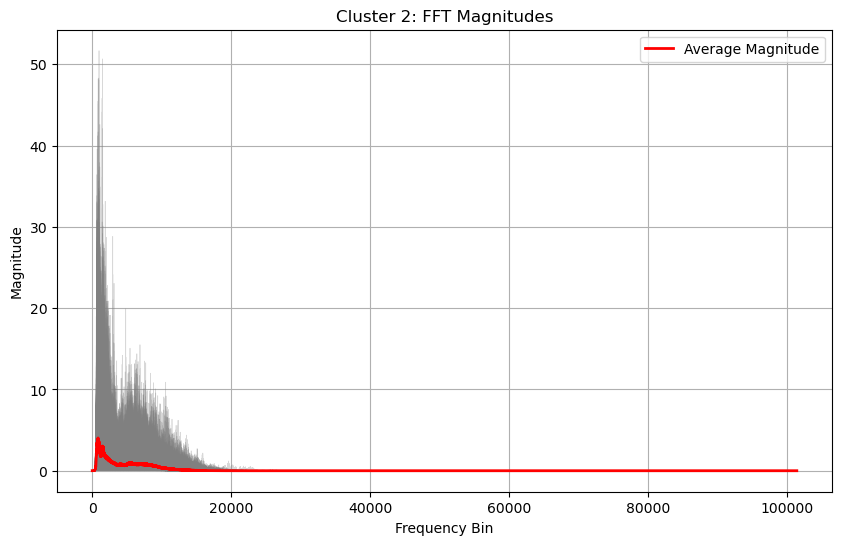

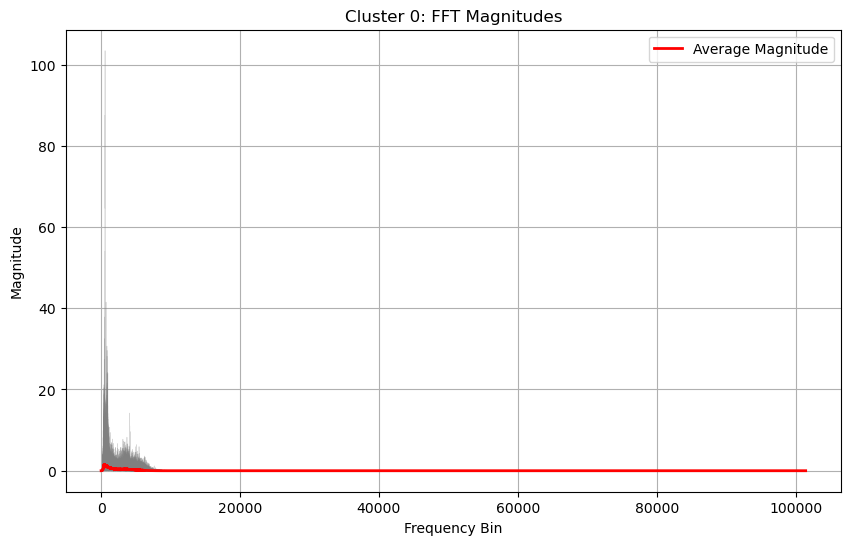

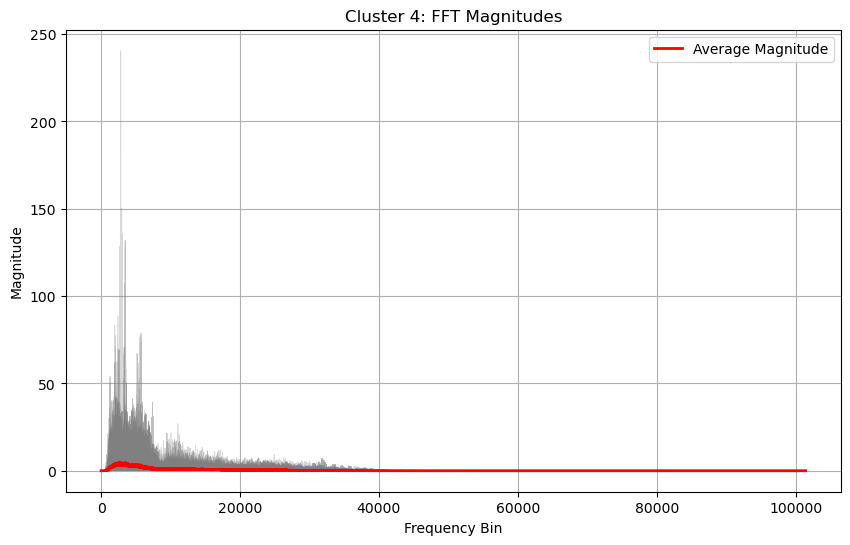

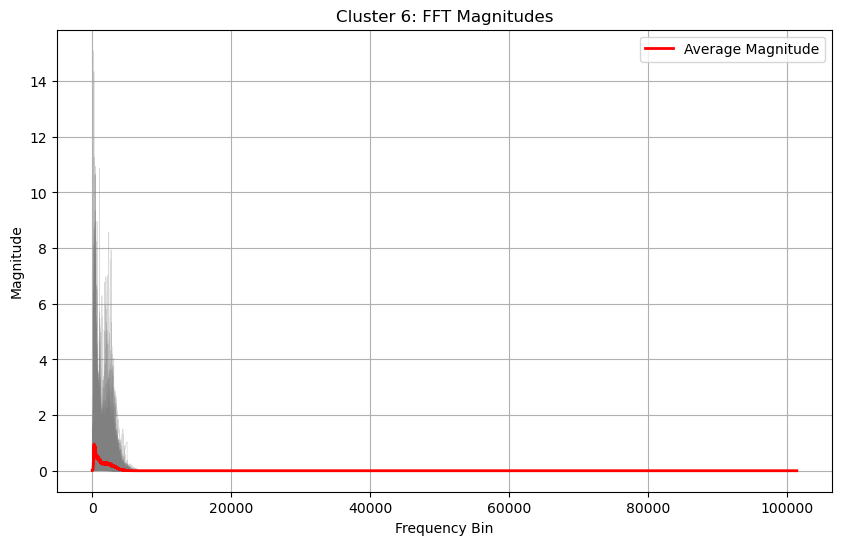

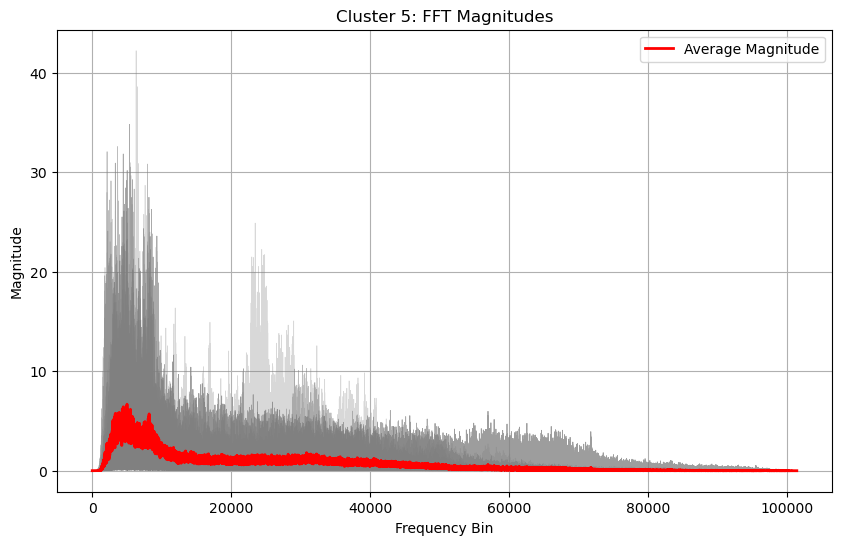

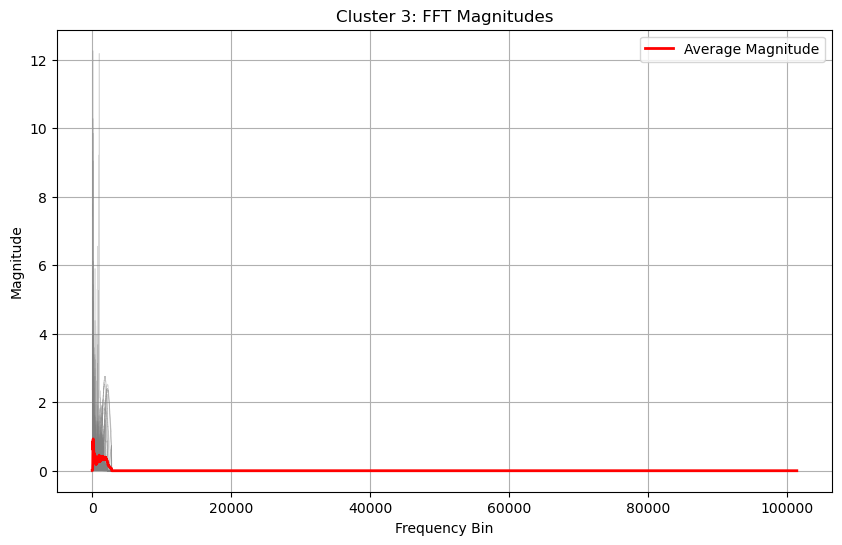

In [17]:
plot_cluster_magnitudes(clusters)